# Multilayer Perceptron for Financial Forecasting

A comprehensive analysis using polynomial detrending, seasonal differencing, and neural networks for time series prediction.

In [227]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
from sklearn.preprocessing import PolynomialFeatures
from sklearn.linear_model import LinearRegression

excel_file = 'M3C.xls'
sheet_name = "M3Month"
category = "FINANCE"

In [228]:
data = pd.read_excel(excel_file, sheet_name=sheet_name)
print("Data loaded")

Data loaded


In [229]:
# Start from the 7th column (index 6) to the end
category_data = data[data['Category'].str.strip() == category]
series = category_data.iloc[2, 6:].dropna().astype(float)  # Changed from iloc[0] to iloc[1] for second series

2. Here we take the first monthly timeseries in the category of finance. We plot it alongside its 2nd degree polynomial trend.

Selected series length: 144 time points


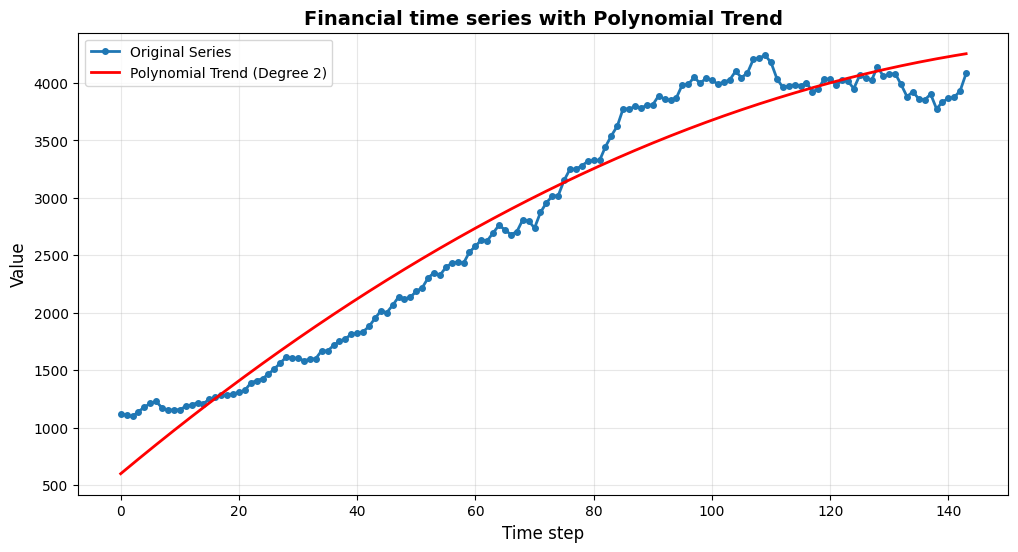

In [230]:
 # One times series with polynomial trend
print(f"Selected series length: {len(series)} time points")
poly = PolynomialFeatures(degree=2)
X = np.arange(len(series)).reshape(-1, 1)
y = series.values

x_poly = poly.fit_transform(X)
poly_model = LinearRegression()
poly_model.fit(x_poly, y)
poly_trend = poly_model.predict(x_poly)

plt.figure(figsize=(12, 6))
plt.plot(series.values, marker='o', linewidth=2, markersize=4, label='Original Series')
plt.plot(poly_trend, color='red', linewidth=2, label='Polynomial Trend (Degree 2)')
plt.title("Financial time series with Polynomial Trend", fontsize=14, fontweight='bold')
plt.legend()
plt.xlabel("Time step", fontsize=12)
plt.ylabel("Value", fontsize=12)
plt.grid(True, alpha=0.3)
plt.show()

3. Next up is de-trending and de-seasonalizing the timeseries to prepare the input for the MLP

Training data length: 120
X_train shape: (108, 12)
y_train shape: (108,)
Validation data length: 12
Mean: 0.000000, Std: 1.000000


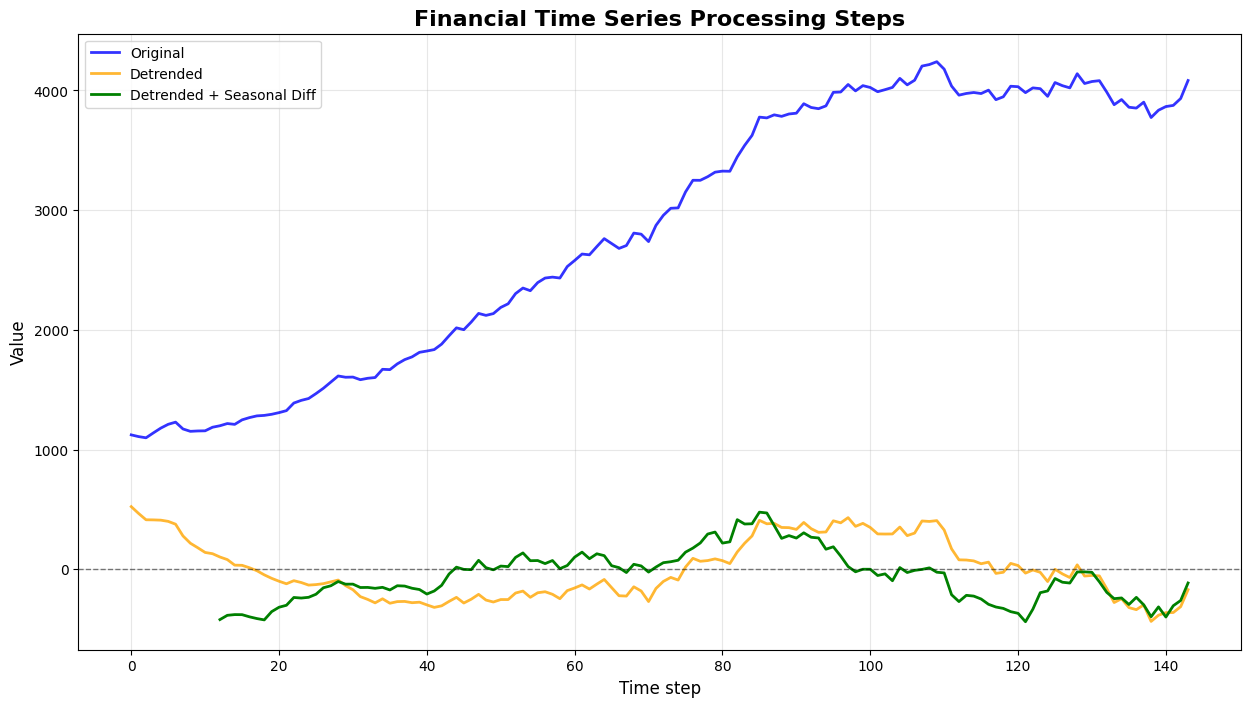

In [231]:
# De-trended and de-seasonal differenced series

de_trended = y - poly_trend

months_in_year = 12
seasonal_diff = list()
for i in range(months_in_year, len(de_trended)):
    value = de_trended[i] - de_trended[i - months_in_year]
    seasonal_diff.append(value)

# Combined plot
plt.figure(figsize=(15, 8))
plt.plot(range(len(y)), y, 'b-', linewidth=2, label='Original', alpha=0.8)
plt.plot(range(len(de_trended)), de_trended, 'orange', linewidth=2, label='Detrended', alpha=0.8)
plt.plot(range(months_in_year, len(de_trended)), seasonal_diff, 'green', linewidth=2, label='Detrended + Seasonal Diff')

plt.title("Financial Time Series Processing Steps", fontsize=16, fontweight='bold')
plt.xlabel("Time step", fontsize=12)
plt.ylabel("Value", fontsize=12)
plt.grid(True, alpha=0.3)
plt.axhline(0, color='black', linewidth=1, linestyle='--', alpha=0.5)
plt.legend()
# Normalize the seasonal_diff data
from sklearn.preprocessing import StandardScaler

scaler = StandardScaler()
seasonal_diff_scaled = scaler.fit_transform(np.array(seasonal_diff).reshape(-1, 1)).flatten()

# Split normalized data: hold out last 12 months for validation
validation_data = seasonal_diff_scaled[-12:]  # Last 12 actual values
training_data = seasonal_diff_scaled[:-12]    # Everything except last 12
# Normalize the seasonal_diff data
from sklearn.preprocessing import StandardScaler

scaler = StandardScaler()
seasonal_diff_scaled = scaler.fit_transform(np.array(seasonal_diff).reshape(-1, 1)).flatten()

# Split normalized data: hold out last 12 months for validation
validation_data = seasonal_diff_scaled[-12:]  # Last 12 actual values
training_data = seasonal_diff_scaled[:-12]    # Everything except last 12

# Function to create sequences for time series
def create_sequences(data, lookback=12):
    """
    Create sequences from time series data
    
    Parameters:
    - data: 1D array of time series values
    - lookback: number of previous time steps to use as input
    
    Returns:
    - X: array of shape (n_samples, lookback) - input sequences
    - y: array of shape (n_samples,) - target values
    """
    X, y = [], []
    for i in range(len(data) - lookback):
        X.append(data[i:i + lookback])
        y.append(data[i + lookback])
    return np.array(X), np.array(y)

# Create sequences from training data only
X_train, y_train = create_sequences(training_data, lookback=12)

print(f"Training data length: {len(training_data)}")
print(f"X_train shape: {X_train.shape}")
print(f"y_train shape: {y_train.shape}")
print(f"Validation data length: {len(validation_data)}")
print(f"Mean: {seasonal_diff_scaled.mean():.6f}, Std: {seasonal_diff_scaled.std():.6f}")



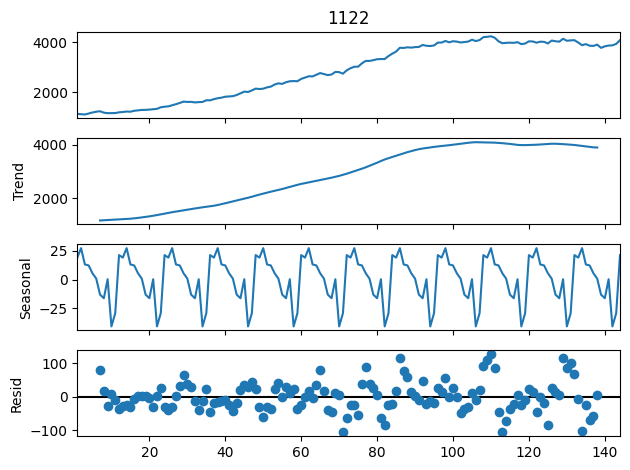

In [232]:
from statsmodels.tsa.seasonal import seasonal_decompose
sd = seasonal_decompose(series, model='additive', period=12).plot()

In [233]:
class MLP:
    def __init__(self, input_size, hidden_size, output_size, learning_rate=0.001):
        # Better weight initialization (He initialization for tanh)
        self.weight_hidden = np.random.randn(input_size, hidden_size) * np.sqrt(2.0 / input_size)
        self.weight_output = np.random.randn(hidden_size, output_size) * np.sqrt(2.0 / hidden_size)
        self.bias_hidden = np.zeros((1, hidden_size))
        self.bias_output = np.zeros((1, output_size))
        self.learning_rate = learning_rate
        self.losses = []

    def tanh(self, x):
        return np.tanh(x)
    
    def tanh_derivative(self, x):
        return 1.0 - np.tanh(x) ** 2

    def forward(self, X):
        # Hidden layer with tanh activation
        self.hidden_input = np.dot(X, self.weight_hidden) + self.bias_hidden
        self.hidden_output = self.tanh(self.hidden_input)
        
        # Output layer with LINEAR activation (no activation for regression)
        self.final_input = np.dot(self.hidden_output, self.weight_output) + self.bias_output
        self.final_output = self.final_input  # Linear output for regression
        
        return self.final_output
    
    def backward(self, X, y, output):
        m = X.shape[0]  # Number of samples
        
        # Reshape y to match output shape
        y = y.reshape(-1, 1)
        
        # Output layer gradient (linear activation, so derivative = 1)
        output_error = output - y  # Shape: (m, 1)
        
        # Hidden layer gradient
        hidden_error = np.dot(output_error, self.weight_output.T) * self.tanh_derivative(self.hidden_input)
        
        # Update weights and biases
        self.weight_output -= self.learning_rate * np.dot(self.hidden_output.T, output_error) / m
        self.bias_output -= self.learning_rate * np.sum(output_error, axis=0, keepdims=True) / m
        self.weight_hidden -= self.learning_rate * np.dot(X.T, hidden_error) / m
        self.bias_hidden -= self.learning_rate * np.sum(hidden_error, axis=0, keepdims=True) / m

    def train(self, X, y, epochs):
        for epoch in range(epochs):
            # Forward pass
            output = self.forward(X)
            
            # Backward pass
            self.backward(X, y, output)
            
            # Calculate MSE loss
            loss = np.mean((output - y.reshape(-1, 1)) ** 2)
            self.losses.append(loss)
            
            if (epoch + 1) % 100 == 0:
                print(f"Epoch {epoch+1}/{epochs}, Loss (MSE): {loss:.6f}")
        
        print(f"Training completed! Final loss: {loss:.6f}")
    
    def predict(self, X):
        """Make predictions on new data"""
        output = self.forward(X)
        return output.flatten()

In [244]:
model = MLP(input_size=12, hidden_size=50, output_size=1, learning_rate=0.001)
model.train(X_train, y_train, epochs=20000)
# Make predictions using TensorFlow model
def forecast_multiple_steps_tf(model, last_sequence, n_steps=12):
    """
    Forecast multiple future time steps using a TensorFlow model.
    
    Parameters:
    - model: Trained TensorFlow model
    - last_sequence: Last input sequence from training data
    - n_steps: Number of future steps to forecast
    
    Returns:
    - predictions: List of predicted values for the next n_steps
    """
    predictions = []
    current_sequence = last_sequence.copy()
    
    for _ in range(n_steps):
        current_sequence_reshaped = current_sequence.reshape((1, -1))
        next_value = model.predict(current_sequence_reshaped)
        predictions.append(next_value[0, 0])
        current_sequence = np.roll(current_sequence, -1)
        current_sequence[-1] = next_value  # Append the predicted value
    
    return np.array(predictions)  



Epoch 100/20000, Loss (MSE): 0.371098
Epoch 200/20000, Loss (MSE): 0.265474
Epoch 300/20000, Loss (MSE): 0.229290
Epoch 400/20000, Loss (MSE): 0.210910
Epoch 500/20000, Loss (MSE): 0.199764
Epoch 600/20000, Loss (MSE): 0.191794
Epoch 700/20000, Loss (MSE): 0.185371
Epoch 800/20000, Loss (MSE): 0.179816
Epoch 900/20000, Loss (MSE): 0.174832
Epoch 1000/20000, Loss (MSE): 0.170273
Epoch 1100/20000, Loss (MSE): 0.166058
Epoch 1200/20000, Loss (MSE): 0.162135
Epoch 1300/20000, Loss (MSE): 0.158467
Epoch 1400/20000, Loss (MSE): 0.155025
Epoch 1500/20000, Loss (MSE): 0.151784
Epoch 1600/20000, Loss (MSE): 0.148724
Epoch 1700/20000, Loss (MSE): 0.145827
Epoch 1800/20000, Loss (MSE): 0.143079
Epoch 1900/20000, Loss (MSE): 0.140466
Epoch 2000/20000, Loss (MSE): 0.137978
Epoch 2100/20000, Loss (MSE): 0.135603
Epoch 2200/20000, Loss (MSE): 0.133334
Epoch 2300/20000, Loss (MSE): 0.131161
Epoch 2400/20000, Loss (MSE): 0.129079
Epoch 2500/20000, Loss (MSE): 0.127081
Epoch 2600/20000, Loss (MSE): 0.12

In [235]:
predictions_scaled = model.predict(X_train)
print("Predictions (scaled):", predictions_scaled)



Predictions (scaled): [-0.7691564  -0.62765519 -0.5525367  -0.31971126 -0.27508338 -0.04882592
 -0.20649787 -0.24808256 -0.44854157 -0.46368208 -0.44580464 -0.37020007
 -0.49986066 -0.30531256 -0.41400661 -0.51989319 -0.56285018 -0.79508381
 -0.57049164 -0.29205172  0.20292402  0.41493479  0.39117645  0.39707418
  0.66639058  0.19860985  0.24481506  0.56038391  0.53867937  0.85396003
  1.01464996  0.58954052  0.70623937  0.5064456   0.81738504  0.37269706
  0.49656049  0.83636855  1.03747649  0.74331249  0.89414955  0.68153349
  0.44242104  0.50416309  0.10408816  0.56015092  0.38004662  0.22635064
  0.44109228  0.55995005  0.63594555  0.68042585  0.90898145  1.0146515
  1.20943511  1.60226363  1.47747492  1.30287175  1.70077945  1.99772051
  1.93045906  2.13696146  2.439567    2.0132      1.68834581  1.37014565
  1.39053675  1.64544612  1.78295513  1.30359265  1.16719639  0.85707961
  0.93172316  0.60956545  0.35113505  0.19086907  0.12378811  0.10580816
  0.05401524  0.29682932 -0.00

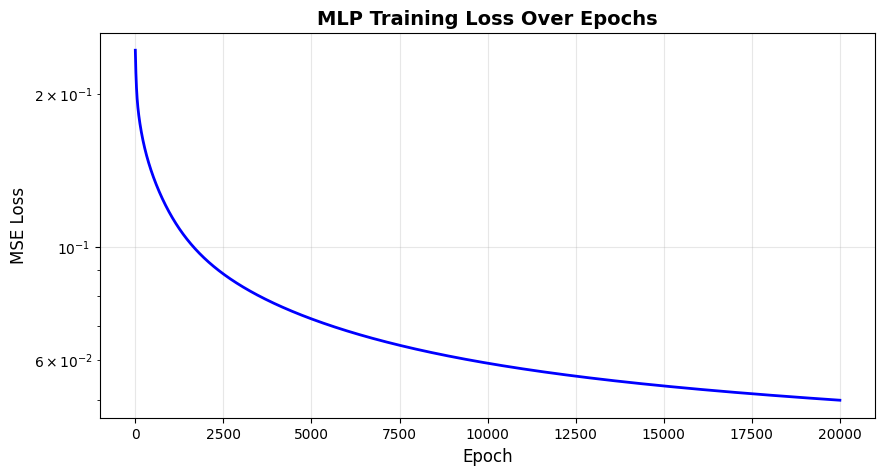

Initial Loss: 0.243274
Final Loss: 0.049917
Loss Reduction: 79.48%


In [236]:
# Plot 1: Training Loss Curve
plt.figure(figsize=(10, 5))
plt.plot(model.losses, linewidth=2, color='blue')
plt.title('MLP Training Loss Over Epochs', fontsize=14, fontweight='bold')
plt.xlabel('Epoch', fontsize=12)
plt.ylabel('MSE Loss', fontsize=12)
plt.grid(True, alpha=0.3)
plt.yscale('log')  # Log scale to better see convergence
plt.show()

print(f"Initial Loss: {model.losses[0]:.6f}")
print(f"Final Loss: {model.losses[-1]:.6f}")
print(f"Loss Reduction: {((model.losses[0] - model.losses[-1]) / model.losses[0] * 100):.2f}%")

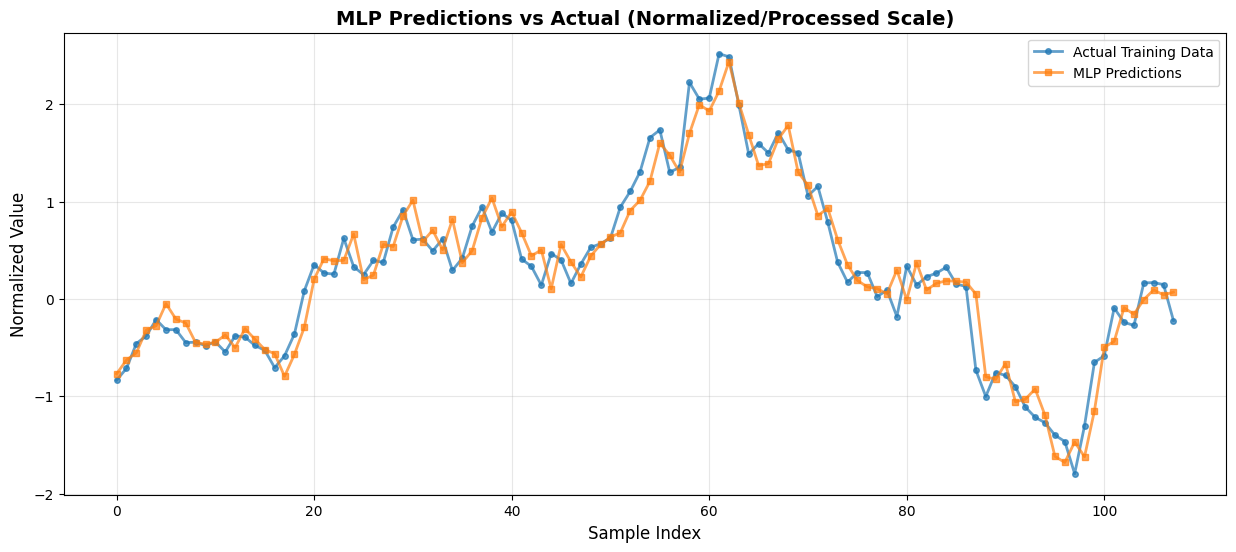

Training MSE: 0.049916
Training MAE: 0.178321


In [237]:
# Plot 2: Predictions vs Actual on Training Data (Processed Scale)
plt.figure(figsize=(15, 6))
plt.plot(y_train, label='Actual Training Data', linewidth=2, marker='o', markersize=4, alpha=0.7)
plt.plot(predictions_scaled, label='MLP Predictions', linewidth=2, marker='s', markersize=4, alpha=0.7)
plt.title('MLP Predictions vs Actual (Normalized/Processed Scale)', fontsize=14, fontweight='bold')
plt.xlabel('Sample Index', fontsize=12)
plt.ylabel('Normalized Value', fontsize=12)
plt.legend()
plt.grid(True, alpha=0.3)
plt.show()

# Calculate training metrics
train_mse = np.mean((predictions_scaled - y_train) ** 2)
train_mae = np.mean(np.abs(predictions_scaled - y_train))
print(f"Training MSE: {train_mse:.6f}")
print(f"Training MAE: {train_mae:.6f}")

In [238]:
# Make predictions for validation period (iterative forecasting)
def forecast_multiple_steps(model, last_sequence, n_steps=12):
    """
    Forecast multiple future time steps iteratively.
    Each prediction becomes part of the input for the next prediction.
    """
    predictions = []
    current_sequence = last_sequence.copy()
    
    for _ in range(n_steps):
        # Predict next value
        next_value = model.predict(current_sequence.reshape(1, -1))[0]
        predictions.append(next_value)
        
        # Update sequence: remove oldest, add newest prediction
        current_sequence = np.roll(current_sequence, -1)
        current_sequence[-1] = next_value
    
    return np.array(predictions)

# Get last 12 values from training data to start forecasting
last_sequence = training_data[-12:]
print(f"Last training sequence shape: {last_sequence.shape}")

# Forecast next 12 months
validation_predictions_scaled = forecast_multiple_steps(model, last_sequence, n_steps=12)

print(f"\nValidation predictions shape: {validation_predictions_scaled.shape}")
print(f"Validation data shape: {validation_data.shape}")

Last training sequence shape: (12,)

Validation predictions shape: (12,)
Validation data shape: (12,)


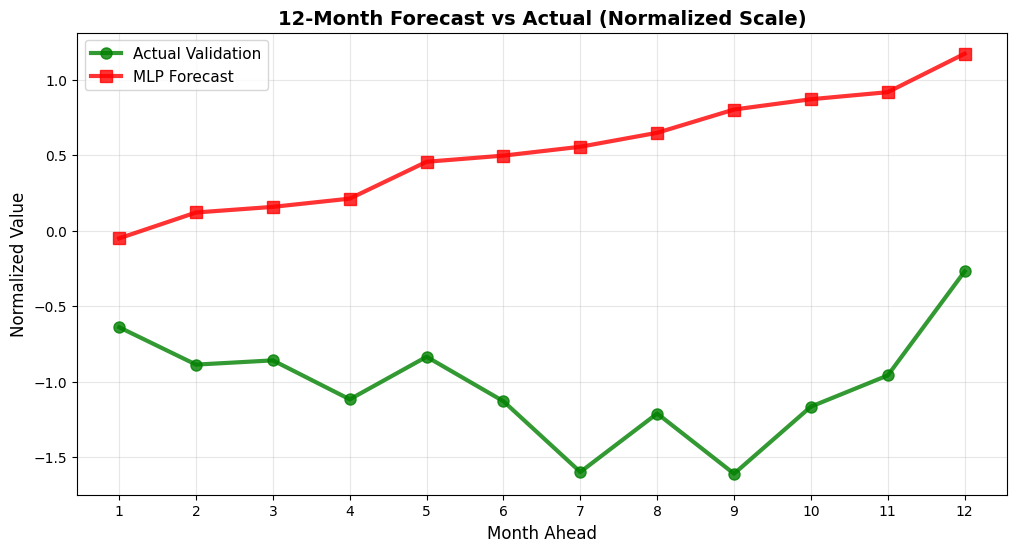


Validation Metrics (Normalized Scale):
MSE: 2.682865
MAE: 1.554753
RMSE: 1.637945


In [239]:
# Plot 3: Validation Predictions vs Actual (Processed Scale)
plt.figure(figsize=(12, 6))
months = np.arange(1, 13)
plt.plot(months, validation_data, 'o-', label='Actual Validation', 
         linewidth=3, markersize=8, color='green', alpha=0.8)
plt.plot(months, validation_predictions_scaled, 's-', label='MLP Forecast', 
         linewidth=3, markersize=8, color='red', alpha=0.8)
plt.title('12-Month Forecast vs Actual (Normalized Scale)', fontsize=14, fontweight='bold')
plt.xlabel('Month Ahead', fontsize=12)
plt.ylabel('Normalized Value', fontsize=12)
plt.legend(fontsize=11)
plt.grid(True, alpha=0.3)
plt.xticks(months)
plt.show()

# Validation metrics
val_mse = np.mean((validation_predictions_scaled - validation_data) ** 2)
val_mae = np.mean(np.abs(validation_predictions_scaled - validation_data))
val_rmse = np.sqrt(val_mse)
print(f"\nValidation Metrics (Normalized Scale):")
print(f"MSE: {val_mse:.6f}")
print(f"MAE: {val_mae:.6f}")
print(f"RMSE: {val_rmse:.6f}")

In [240]:
# Reverse transformations: Convert predictions back to original scale
print("="*60)
print("REVERSING TRANSFORMATIONS")
print("="*60)

# Step 1: Denormalize predictions
validation_predictions_denorm = scaler.inverse_transform(
    validation_predictions_scaled.reshape(-1, 1)
).flatten()

validation_actual_denorm = scaler.inverse_transform(
    validation_data.reshape(-1, 1)
).flatten()

print("\nStep 1 - Denormalized:")
print(f"Predictions: {validation_predictions_denorm[:3]}...")
print(f"Actual: {validation_actual_denorm[:3]}...")

# Step 2: Reverse seasonal differencing
# We need the detrended values from 12 months before the validation period
reference_values = de_trended[-(24):-12]

# Add back the seasonal component
validation_predictions_deseasoned = validation_predictions_denorm + reference_values
validation_actual_deseasoned = validation_actual_denorm + reference_values

print("\nStep 2 - Reverse seasonal differencing:")
print(f"Predictions: {validation_predictions_deseasoned[:3]}...")
print(f"Actual: {validation_actual_deseasoned[:3]}...")

# Step 3: Add back polynomial trend
# Get trend values for the validation period (last 12 points)
validation_trend = poly_trend[-12:]

validation_predictions_original = validation_predictions_deseasoned + validation_trend
validation_actual_original = validation_actual_deseasoned + validation_trend

print("\nStep 3 - Add back trend:")
print(f"Predictions: {validation_predictions_original[:3]}...")
print(f"Actual: {validation_actual_original[:3]}...")
print(f"\nOriginal validation values from series:")
print(f"Series: {y[-12:][:3]}...")
print("="*60)

REVERSING TRANSFORMATIONS

Step 1 - Denormalized:
Predictions: [-68.3927346  -32.04588988 -24.15400634]...
Actual: [-193.39017808 -245.9130629  -239.96594772]...

Step 2 - Reverse seasonal differencing:
Predictions: [-37.54944691 -64.49837815 -30.31001097]...
Actual: [-162.54689039 -278.36555117 -246.12195236]...

Step 3 - Add back trend:
Predictions: [4111.42744348 4095.25717302 4139.98194138]...
Actual: [3986.43 3881.39 3924.17]...

Original validation values from series:
Series: [3986.43 3881.39 3924.17]...


In [241]:
# Calculate metrics on original scale
original_mse = np.mean((validation_predictions_original - y[-12:]) ** 2)
original_mae = np.mean(np.abs(validation_predictions_original - y[-12:]))
original_rmse = np.sqrt(original_mse)
original_mape = np.mean(np.abs((y[-12:] - validation_predictions_original) / y[-12:])) * 100

print("="*60)
print("FINAL METRICS ON ORIGINAL SCALE")
print("="*60)
print(f"MSE:  {original_mse:.2f}")
print(f"MAE:  {original_mae:.2f}")
print(f"RMSE: {original_rmse:.2f}")
print(f"MAPE: {original_mape:.2f}%")
print("="*60)

# Month-by-month comparison
comparison_df = pd.DataFrame({
    'Month': range(1, 13),
    'Actual': y[-12:],
    'Predicted': validation_predictions_original,
    'Error': validation_predictions_original - y[-12:],
    'Abs_Error': np.abs(validation_predictions_original - y[-12:]),
    'Pct_Error': ((validation_predictions_original - y[-12:]) / y[-12:]) * 100
})

print("\nMonth-by-Month Comparison:")
print(comparison_df.to_string(index=False))

FINAL METRICS ON ORIGINAL SCALE
MSE:  120659.20
MAE:  329.72
RMSE: 347.36
MAPE: 8.49%

Month-by-Month Comparison:
 Month  Actual   Predicted      Error  Abs_Error  Pct_Error
     1 3986.43 4111.427443 124.997443 124.997443   3.135574
     2 3881.39 4095.257173 213.867173 213.867173   5.510067
     3 3924.17 4139.981941 215.811941 215.811941   5.499556
     4 3860.00 4142.179934 282.179934 282.179934   7.310361
     5 3852.95 4127.073987 274.123987 274.123987   7.114652
     6 3902.48 4247.841395 345.361395 345.361395   8.849793
     7 3774.16 4231.397054 457.237054 457.237054  12.114936
     8 3835.16 4229.812078 394.652078 394.652078  10.290368
     9 3865.69 4377.691328 512.001328 512.001328  13.244759
    10 3875.46 4307.591894 432.131894 432.131894  11.150467
    11 3933.07 4331.269887 398.199887 398.199887  10.124404
    12 4083.35 4389.398392 306.048392 306.048392   7.495032


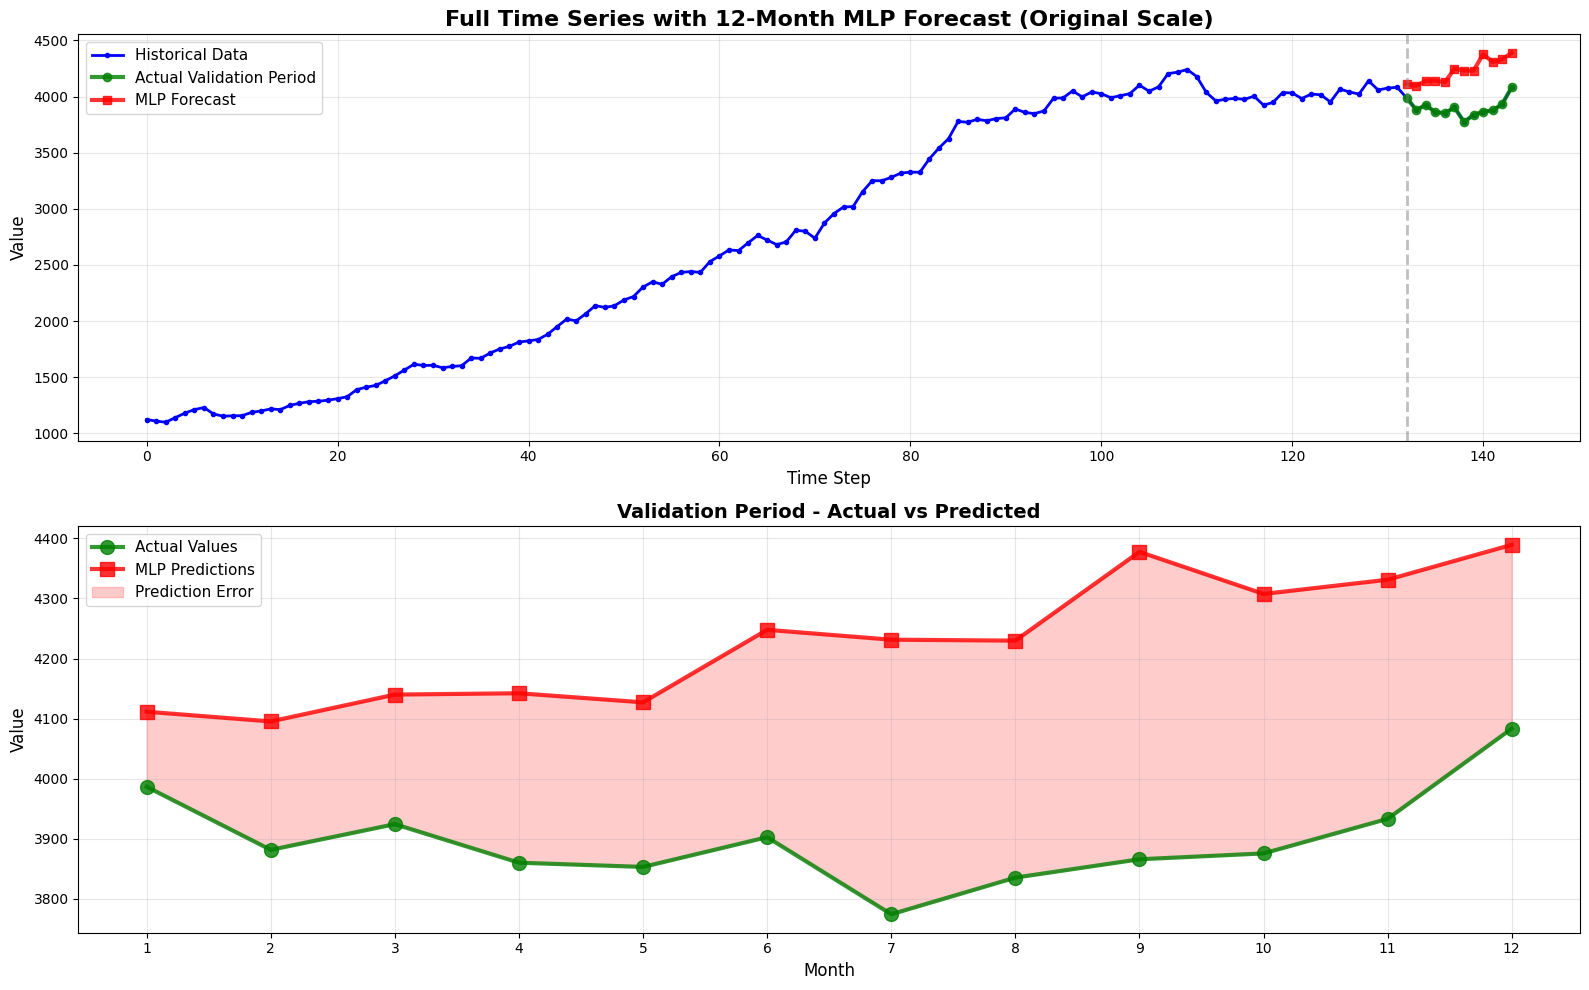

In [242]:
# Plot 4: Full Time Series with Forecast (Original Scale)
fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(16, 10))

# Top plot: Full series
ax1.plot(range(len(y)), y, 'b-', linewidth=2, label='Historical Data', marker='o', markersize=3)
ax1.plot(range(len(y) - 12, len(y)), y[-12:], 'go-', linewidth=3, 
         markersize=6, label='Actual Validation Period', alpha=0.8)
ax1.plot(range(len(y) - 12, len(y)), validation_predictions_original, 'rs-', 
         linewidth=3, markersize=6, label='MLP Forecast', alpha=0.8)
ax1.axvline(len(y) - 12, color='gray', linestyle='--', linewidth=2, alpha=0.5)
ax1.set_title('Full Time Series with 12-Month MLP Forecast (Original Scale)', 
              fontsize=16, fontweight='bold')
ax1.set_xlabel('Time Step', fontsize=12)
ax1.set_ylabel('Value', fontsize=12)
ax1.legend(fontsize=11)
ax1.grid(True, alpha=0.3)

# Bottom plot: Zoomed validation period
months = np.arange(1, 13)
ax2.plot(months, y[-12:], 'go-', linewidth=3, markersize=10, 
         label='Actual Values', alpha=0.8)
ax2.plot(months, validation_predictions_original, 'rs-', linewidth=3, 
         markersize=10, label='MLP Predictions', alpha=0.8)
ax2.fill_between(months, y[-12:], validation_predictions_original, 
                  alpha=0.2, color='red', label='Prediction Error')
ax2.set_title('Validation Period - Actual vs Predicted', fontsize=14, fontweight='bold')
ax2.set_xlabel('Month', fontsize=12)
ax2.set_ylabel('Value', fontsize=12)
ax2.legend(fontsize=11)
ax2.grid(True, alpha=0.3)
ax2.set_xticks(months)

plt.tight_layout()
plt.show()

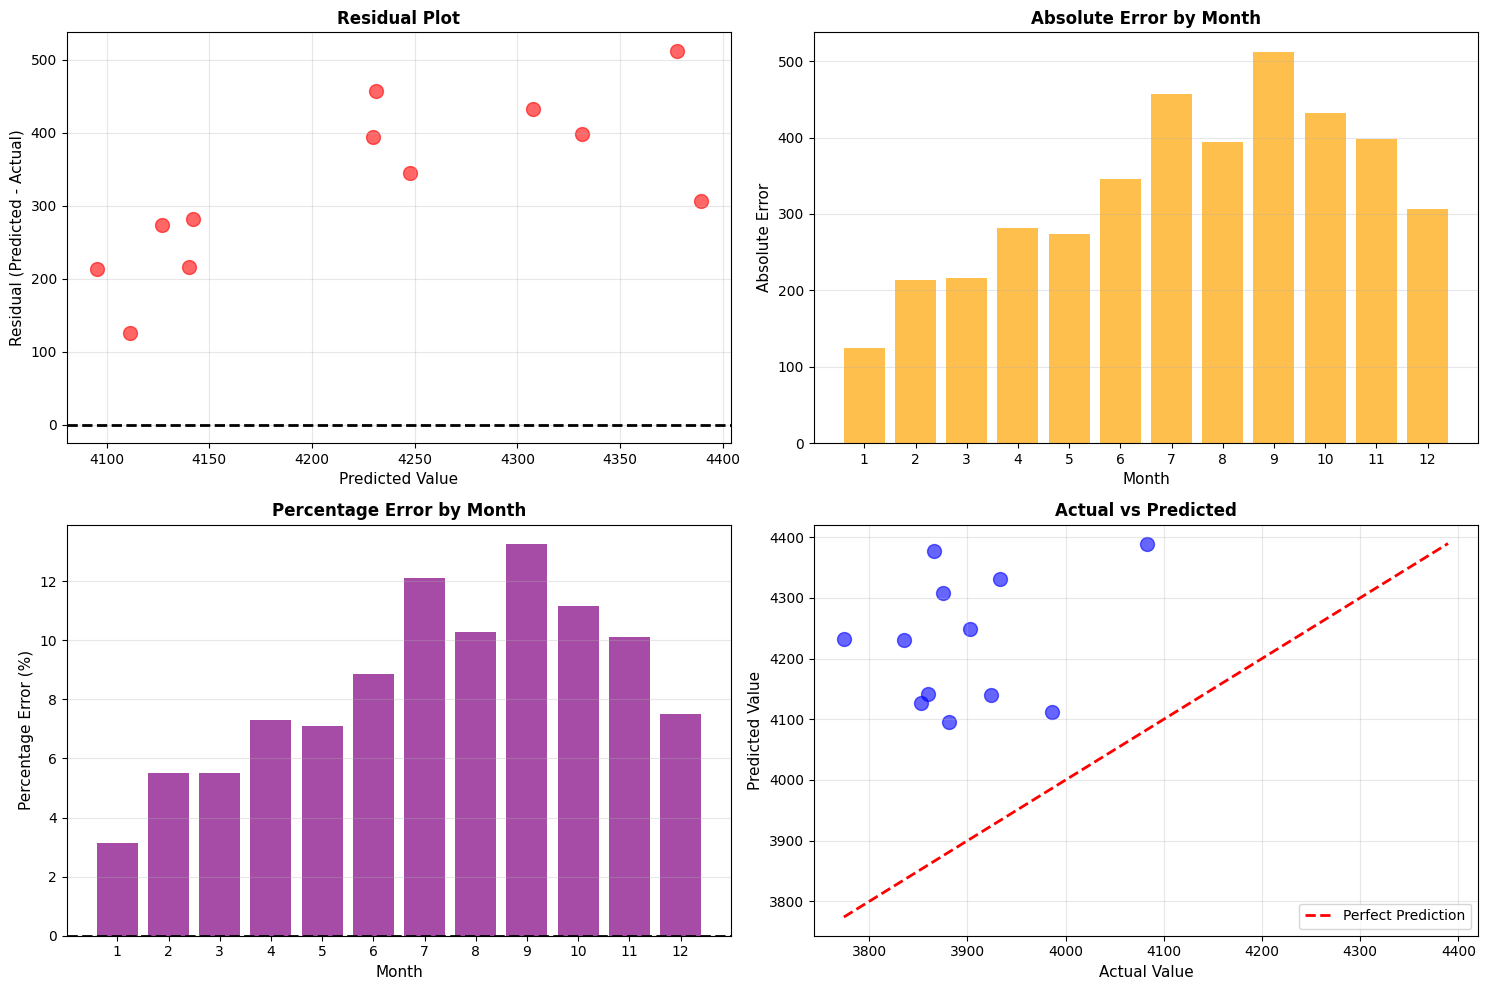

In [243]:
# Plot 5: Error Analysis
fig, axes = plt.subplots(2, 2, figsize=(15, 10))

# 1. Residual plot
axes[0, 0].scatter(validation_predictions_original, 
                   validation_predictions_original - y[-12:], 
                   s=100, alpha=0.6, color='red')
axes[0, 0].axhline(0, color='black', linestyle='--', linewidth=2)
axes[0, 0].set_xlabel('Predicted Value', fontsize=11)
axes[0, 0].set_ylabel('Residual (Predicted - Actual)', fontsize=11)
axes[0, 0].set_title('Residual Plot', fontsize=12, fontweight='bold')
axes[0, 0].grid(True, alpha=0.3)

# 2. Absolute error by month
axes[0, 1].bar(months, np.abs(validation_predictions_original - y[-12:]), 
               color='orange', alpha=0.7)
axes[0, 1].set_xlabel('Month', fontsize=11)
axes[0, 1].set_ylabel('Absolute Error', fontsize=11)
axes[0, 1].set_title('Absolute Error by Month', fontsize=12, fontweight='bold')
axes[0, 1].grid(True, alpha=0.3, axis='y')
axes[0, 1].set_xticks(months)

# 3. Percentage error by month
axes[1, 0].bar(months, comparison_df['Pct_Error'], color='purple', alpha=0.7)
axes[1, 0].axhline(0, color='black', linestyle='--', linewidth=2)
axes[1, 0].set_xlabel('Month', fontsize=11)
axes[1, 0].set_ylabel('Percentage Error (%)', fontsize=11)
axes[1, 0].set_title('Percentage Error by Month', fontsize=12, fontweight='bold')
axes[1, 0].grid(True, alpha=0.3, axis='y')
axes[1, 0].set_xticks(months)

# 4. Actual vs Predicted scatter
axes[1, 1].scatter(y[-12:], validation_predictions_original, s=100, alpha=0.6, color='blue')
# Perfect prediction line
min_val = min(y[-12:].min(), validation_predictions_original.min())
max_val = max(y[-12:].max(), validation_predictions_original.max())
axes[1, 1].plot([min_val, max_val], [min_val, max_val], 'r--', linewidth=2, label='Perfect Prediction')
axes[1, 1].set_xlabel('Actual Value', fontsize=11)
axes[1, 1].set_ylabel('Predicted Value', fontsize=11)
axes[1, 1].set_title('Actual vs Predicted', fontsize=12, fontweight='bold')
axes[1, 1].legend(fontsize=10)
axes[1, 1].grid(True, alpha=0.3)

plt.tight_layout()
plt.show()